In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

# 短语情感分类

对Phrase字段中的文本进行分类，分类结果为

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [19]:
train = pd.read_csv('train.tsv', sep='\t')
print("Sentiment Count")
print(train.Sentiment.value_counts())
train.sample(20)

Sentiment Count
2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


,PhraseId,SentenceId,Phrase,Sentiment
49188,49189,2404,call Reno,2
144435,144436,7843,broad and,2
35467,35468,1669,another example of how Sandler is losing his t...,1
137448,137449,7437,It 's tough to watch,0
124582,124583,6694,verbally flatfooted,1
7701,7702,311,a biting satire,3
26500,26501,1216,A crass and insulting homage,1
76959,76960,3958,In a summer of clones,1
126957,126958,6825,a stultifying,2
34815,34816,1638,mechanical you can smell the grease on the plot,1


## 1. 数据预处理
1. 统计单词频率并保留频率最高的100000个单词，构建单词到索引的映射，以及构建索引到单词的映射。

In [21]:
# 探索阶段，可放开以下注释，仅使用头1000行数据
# train = train.head(1000)

# 创建字典
len_list = []
word_freq_map = defaultdict(int)
for sentence in train.Phrase:
    words = str(sentence).split()
    words = [w.lower() for w in words] # 统一为小写
    len_list.append(len(words))
    for word in words:
        word_freq_map[word] += 1

word_freq_map = dict(sorted(word_freq_map.items(),
                                   key=lambda x: x[1], reverse=True))
top_k_words = 100000
# 使用列表根据序号查找单词 (特殊词 <UNK> 表示未登录词)
idx2word = list(word_freq_map.keys())[:top_k_words] + ['<UNK>', '<PAD>'] # 
# 使用词典根据单词查找序号
word2idx = {idx2word[i]:i for i in range(len(idx2word))}
print('<UNK>:', word2idx['<UNK>'])

<UNK>: 16531


2. 构建基于词序号的数据集，为词向量做准备

In [24]:
# 处理句子数据
def preprocess_sentence(sentence,  word2idx, max_len):
    x = np.ones(max_len,dtype=np.int64)*word2idx['<PAD>'] # 默认全部为填充词<PAD>
    words = str(sentence).split()
    words = [w.lower() for w in words][:max_len]
    for i,w in enumerate(words):
        if w in word2idx:
            x[i]=word2idx[w]
        else:
            x[i]=word2idx['<UNK>']
    return x

# 处理语料库
def extract_word_index_feat(df, word2idx, max_len=40):
    X = []
    for sentence in df.Phrase:
        x = preprocess_sentence(sentence, word2idx, max_len)
        X.append(x)
    X = np.array(X)
    y = np.array(df.Sentiment)
    return X, y

X,y = extract_word_index_feat(train, word2idx)

# 数据集结构定义
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# 数据集划分
train_num = int(len(X) * 0.8)
X_train = X[:train_num]
y_train = y[:train_num]
X_val = X[train_num:]
y_val = y[train_num:]


# 创建训练与验证数据集
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)

## 2. 模型

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# 模型定义
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim, vocab_size, embedding_dim):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(embedding_dim * input_dim, hid_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_dim, output_dim)  # 5 classes for classification

    def forward(self, x):
        x = self.embedding(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

# 创建模型实例
model = MLP(input_dim=40, hid_dim=100, output_dim=5, 
            vocab_size=len(idx2word), embedding_dim=50)

## 3. 学习准则（策略）

In [29]:
# 交叉熵
criterion = nn.CrossEntropyLoss()

## 4. 优化（算法）

In [26]:
# 随机梯度下降算法SGD的变种
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 5. 训练过程

In [27]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [] # 训练损失
val_losses = [] # 验证损失
train_accuracies = [] # 训练精度
val_accuracies = [] # 验证精度
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 计算设备使用GPU或CPU（GPU优先）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练多个回合
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # 若有GPU，数据移到GPU显存
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_acc = (train_correct / len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 若有GPU，数据移到GPU显存
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = (correct / len(val_loader.dataset)) * 100
    val_accuracies.append(val_acc)

    # 打印训练和验证的损失和精度
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch 1/10, Loss: 1.1714, Val Loss: 1.3481, Train Acc: 73.30%, Val Acc: 55.23%
Epoch 2/10, Loss: 1.1641, Val Loss: 1.3490, Train Acc: 74.05%, Val Acc: 55.16%
Epoch 3/10, Loss: 1.1585, Val Loss: 1.3481, Train Acc: 74.61%, Val Acc: 55.34%
Epoch 4/10, Loss: 1.1537, Val Loss: 1.3475, Train Acc: 75.10%, Val Acc: 55.37%
Epoch 5/10, Loss: 1.1495, Val Loss: 1.3497, Train Acc: 75.49%, Val Acc: 55.10%
Epoch 6/10, Loss: 1.1455, Val Loss: 1.3523, Train Acc: 75.89%, Val Acc: 54.84%
Epoch 7/10, Loss: 1.1427, Val Loss: 1.3473, Train Acc: 76.18%, Val Acc: 55.44%
Epoch 8/10, Loss: 1.1399, Val Loss: 1.3503, Train Acc: 76.46%, Val Acc: 55.13%
Epoch 9/10, Loss: 1.1364, Val Loss: 1.3521, Train Acc: 76.83%, Val Acc: 54.94%
Epoch 10/10, Loss: 1.1342, Val Loss: 1.3536, Train Acc: 77.04%, Val Acc: 54.76%


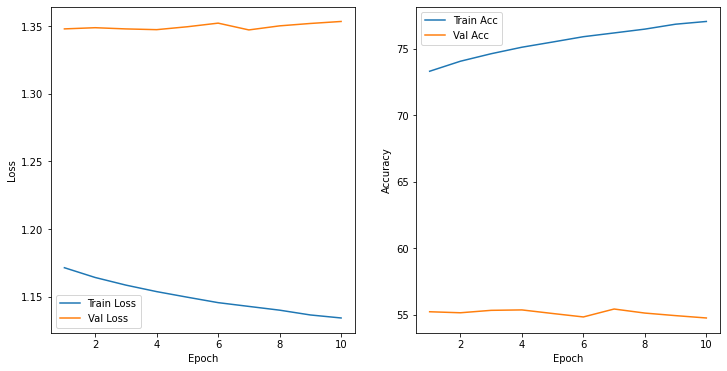

In [28]:
# 对训练和验证集上的损失和精度按照回合数进行可视化
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('loss_acc_plot.png')
plt.show()

## 6. 测试
测试结果可提交后查看精度表现
https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews

In [32]:
test = pd.read_csv('test.tsv', sep='\t')
test['Sentiment'] = 0 # add fake label
X_test,y_test = extract_word_index_feat(test, word2idx)
test_dataset = SentimentDataset(X_test, y_test)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
all_predicted = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.append(predicted.cpu().numpy())
y_test = np.concatenate(all_predicted)
test['Sentiment']=y_test
selected_columns = ['PhraseId', 'Sentiment']
test[selected_columns].to_csv('Sentiment_wordemb_MLP.csv', index=False)

In [33]:
!ls

Sentiment_BoW_MLP.csv                  sentiment_wordemb_lstm_gloveinit.ipynb
Sentiment_wordemb_MLP.csv              sentiment_wordemb_mlp.ipynb
loss_acc_plot.png                      sentiment_wordemb_mlp_gloveinit.ipynb
sentiment_bow_mlp.ipynb                test.tsv
sentiment_bow_mlp.py                   train.tsv
